In [31]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import sklearn
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

import joblib, json, warnings
warnings.filterwarnings("ignore")


DATA_PATH = Path("/content/car_sales_data.csv")
SEED = 42
np.random.seed(SEED)

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error en % (más interpretable para negocio)."""
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), eps, None))) * 100.0


In [18]:
assert DATA_PATH.exists(), f"No encuentro el archivo en {DATA_PATH}."
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(3))
display(df.dtypes.to_frame("dtype"))


Shape: (50000, 7)


,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072


,dtype
Manufacturer,object
Model,object
Engine size,float64
Fuel type,object
Year of manufacture,int64
Mileage,int64
Price,int64


Carga de datos

In [19]:
def find_col(df, candidates):
    """Busca nombres exactos y, si no, por 'contains' (robusto a nombres distintos)."""
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    for name in df.columns:
        for cand in candidates:
            if cand.lower() in name.lower():
                return name
    return None

col_price   = find_col(df, ['sale_price','sales_price','price','final_sale_price','final_price'])
col_year    = find_col(df, ['year','year_of_manufacture','manufacture_year'])
col_mileage = find_col(df, ['mileage','mileage_run','odometer','km','kilometers'])
col_make    = find_col(df, ['make','car_make','manufacturer','brand'])
col_model   = find_col(df, ['model','car_model','version','trim'])
col_fuel    = find_col(df, ['fuel_type','fuel','fueltype'])
col_engine  = find_col(df, ['engine','engine_size','engine_cc','displacement','cc','engine_capacity','horsepower','hp'])
col_trans   = find_col(df, ['transmission','gearbox'])
col_location= find_col(df, ['location','region','customer_location','city'])

print("Target(price):", col_price)
print("Year:", col_year, "| Mileage:", col_mileage)
print("Make:", col_make, "| Model:", col_model, "| Fuel:", col_fuel)
print("Engine:", col_engine, "| Transmission:", col_trans, "| Location:", col_location)


Target(price): Price
Year: Year of manufacture | Mileage: Mileage
Make: Manufacturer | Model: Model | Fuel: Fuel type
Engine: Engine size | Transmission: None | Location: None


Analisis y limpieza

In [20]:
# Selección de columnas útiles
must = [col_price]
opt  = [col_year, col_mileage, col_make, col_model, col_fuel, col_engine, col_trans, col_location]
use_cols = [c for c in must + opt if c is not None]
df_ = df[use_cols].copy()

# % de nulos
print("Porcentaje de nulos (top 10):")
display(df_.isna().mean().sort_values(ascending=False).head(10))

# Imputaciones conservadoras
for c in df_.columns:
    if df_[c].dtype.kind in "biufc":
        if df_[c].isna().any(): df_[c].fillna(df_[c].median(), inplace=True)
    else:
        if df_[c].isna().any(): df_[c].fillna("Unknown", inplace=True)

# Feature clave: Age = año actual - Year (sanity 0..60)
if col_year:
    current_year = datetime.now().year
    df_["Age"] = (current_year - df_[col_year].astype(float)).clip(lower=0, upper=60)
else:
    df_["Age"] = np.nan

# Reglas de sanidad
if col_price:   df_ = df_[ df_[col_price] > 0 ]
if col_mileage: df_ = df_[ df_[col_mileage] >= 0 ]

print("Post-clean shape:", df_.shape)
display(df_.head(3))


Porcentaje de nulos (top 10):


,0
Price,0.0
Year of manufacture,0.0
Mileage,0.0
Manufacturer,0.0
Model,0.0
Fuel type,0.0
Engine size,0.0


Post-clean shape: (50000, 8)


,Price,Year of manufacture,Mileage,Manufacturer,Model,Fuel type,Engine size,Age
0,3074,2002,127300,Ford,Fiesta,Petrol,1.0,23.0
1,49704,2016,57850,Porsche,718 Cayman,Petrol,4.0,9.0
2,24072,2014,39190,Ford,Mondeo,Diesel,1.6,11.0


Part train/test

In [21]:

#  GroupKFold

from sklearn.model_selection import GroupKFold
import pandas as pd
import numpy as np


y = df_[col_price].astype(float)
X = df_.drop(columns=[col_price])


group_cols = [c for c in [col_make, col_model, col_year] if c is not None and c in X.columns]

if group_cols:
    groups = X[group_cols].astype(str).agg("|".join, axis=1)
else:

    groups = pd.Series("all", index=X.index)

# Instancia de GroupKFold
gkf = GroupKFold(n_splits=5)


splits = list(gkf.split(X, y, groups))
tr_idx, va_idx = splits[0]

X_train, X_test = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
y_train, y_test = y.iloc[tr_idx].copy(), y.iloc[va_idx].copy()

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Ejemplo de grupos en test:", groups.iloc[va_idx].head().tolist())


Train shape: (40000, 7) | Test shape: (10000, 7)
Ejemplo de grupos en test: ['VW|Polo|2006', 'Toyota|RAV4|2007', 'Toyota|Yaris|1992', 'Toyota|Prius|1990', 'Toyota|Prius|2017']


In [26]:
df_ = df_[df_[col_price].between(1000, df_[col_price].quantile(0.995))]


Preprocesamiento

In [27]:
if "Age" in X.columns:
    X["Age"] = pd.to_numeric(X["Age"], errors="coerce")

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"#num_cols={len(num_cols)} | #cat_cols={len(cat_cols)}")

if sklearn.__version__ >= "1.2":
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)  # API nueva
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)         # API legacy

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop"
)

# Baseline
pipe_dummy = Pipeline([
    ("prep", preprocess),
    ("model", DummyRegressor(strategy="median"))
])
pipe_dummy.fit(X_train, y_train)
pred_dummy = pipe_dummy.predict(X_test)
mae_dummy  = mean_absolute_error(y_test, pred_dummy)

def mape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), eps, None))) * 100.0

mape_dummy = mape(y_test, pred_dummy)
print(f"Baseline Dummy -> MAE: {mae_dummy:,.2f} | MAPE%: {mape_dummy:,.2f}")

# Baseline
pipe_en = Pipeline([
    ("prep", preprocess),
    ("model", ElasticNet(random_state=SEED))
])
pipe_en.fit(X_train, y_train)
pred_en = pipe_en.predict(X_test)
mae_en  = mean_absolute_error(y_test, pred_en)
mape_en = mape(y_test, pred_en)
print(f"Elastic Net -> MAE: {mae_en:,.2f} | MAPE%: {mape_en:,.2f}")


#num_cols=4 | #cat_cols=3
Baseline Dummy -> MAE: 10,201.92 | MAPE%: 195.89
Elastic Net -> MAE: 5,283.39 | MAPE%: 162.39


Gradient Boosting Regressor

In [10]:
def make_qgbm(alpha):
    return Pipeline([
        ("prep", preprocess),
        ("model", GradientBoostingRegressor(
            loss="quantile", alpha=alpha, random_state=SEED,
            max_depth=3, n_estimators=400, learning_rate=0.05
        ))
    ])

q10 = make_qgbm(0.10); q10.fit(X_train, y_train)
q50 = make_qgbm(0.50); q50.fit(X_train, y_train)
q90 = make_qgbm(0.90); q90.fit(X_train, y_train)

pred_p50 = q50.predict(X_test)
mae_p50  = mean_absolute_error(y_test, pred_p50)
mape_p50 = mape(y_test, pred_p50)
print(f"Q50 (mediana) -> MAE: {mae_p50:,.2f} | MAPE%: {mape_p50:,.2f}")

# Cobertura banda P10–P90 y ancho relativo
p10 = q10.predict(X_test); p90 = q90.predict(X_test)
coverage = np.mean((y_test.values >= p10) & (y_test.values <= p90)) * 100.0
band_width = np.mean((p90 - p10) / np.maximum(1.0, np.abs(pred_p50)))
print(f"Cobertura [P10,P90]: {coverage:.2f}% | Ancho relativo medio: {band_width:.3f}")


Q50 (mediana) -> MAE: 838.32 | MAPE%: 8.00
Cobertura [P10,P90]: 79.94% | Ancho relativo medio: 0.345


In [22]:

#  Validación cruzada 5-fold con GroupKFold para q50

cv_scores = []

for fold, (tr, va) in enumerate(splits, 1):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]


    q50_cv = make_qgbm(0.50)
    q50_cv.fit(X_tr, y_tr)
    pred_va = q50_cv.predict(X_va)

    mae_cv  = mean_absolute_error(y_va, pred_va)
    mape_cv = mape(y_va, pred_va)
    cv_scores.append({"fold": fold, "MAE": mae_cv, "MAPE%": mape_cv})

cv_df = pd.DataFrame(cv_scores)
print("Resultados CV GroupKFold (5 folds):")
display(cv_df)
print("Promedio:")
display(cv_df[["MAE","MAPE%"]].mean().to_frame("mean").T)
print("Desviación estándar:")
display(cv_df[["MAE","MAPE%"]].std().to_frame("std").T)


Resultados CV GroupKFold (5 folds):


,fold,MAE,MAPE%
0,1,968.574154,9.054000
1,2,1055.397088,9.924282
2,3,1296.879644,8.537030
3,4,1282.817350,10.511745
4,5,1264.803588,8.898345


Promedio:


,MAE,MAPE%
mean,1173.694365,9.38508


Desviación estándar:


,MAE,MAPE%
std,151.205056,0.81022


Explicabilidad


Permutation Importance + PDP (Age / Mileage)


Top-15 importancias (perm):


,0
Mileage,0.304164
Year of manufacture,0.234587
Engine size,0.197592
Age,0.155493
Model,0.121069
Manufacturer,0.023168
Fuel type,0.011716


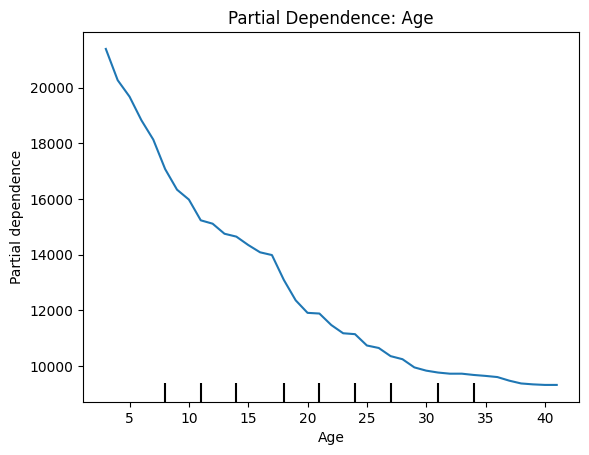

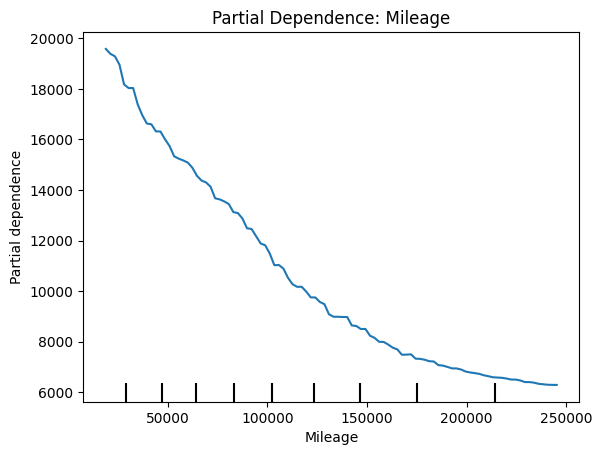

In [11]:
# Importancias por permutación (agnóstico al modelo)
r = permutation_importance(q50, X_test, y_test, n_repeats=5, random_state=SEED, n_jobs=1)
imp = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False).head(15)
print("Top-15 importancias (perm):")
display(imp)

# PDP para Age y una columna de Mileage (si existen)
features_to_plot = []
if "Age" in X_test.columns: features_to_plot.append("Age")
# detectar candidate de kilometraje
for c in X_test.columns:
    if any(m in c.lower() for m in ["mileage","odometer","km"]):
        features_to_plot.append(c); break

if features_to_plot:
    for f in features_to_plot:
        try:
            PartialDependenceDisplay.from_estimator(q50, X_test, [f], kind="average")
            plt.title(f"Partial Dependence: {f}")
            plt.show()
        except Exception as e:
            print("PDP skip:", f, e)
else:
    print("No hay Age/Mileage para PDP.")


Residuales

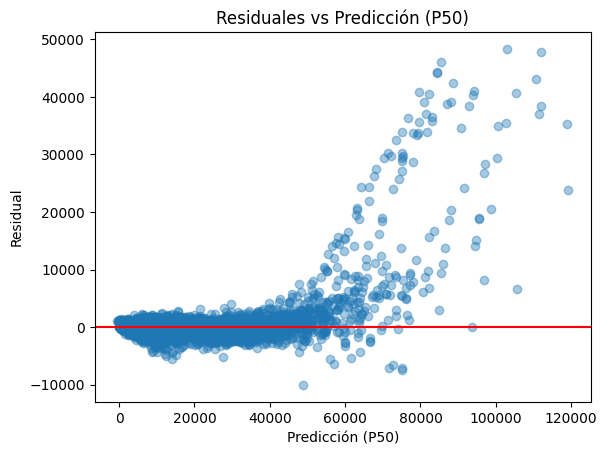

APE percentiles [50, 75, 90, 95]: [ 4.78034354  9.60505332 17.56696154 26.04972478]


In [12]:
resid = y_test - pred_p50
plt.figure()
plt.scatter(pred_p50, resid, alpha=0.4)
plt.axhline(0, color="r")
plt.title("Residuales vs Predicción (P50)")
plt.xlabel("Predicción (P50)")
plt.ylabel("Residual")
plt.show()

ape = np.abs(resid) / np.maximum(np.abs(y_test), 1e-6) * 100.0
print("APE percentiles [50, 75, 90, 95]:", np.percentile(ape, [50,75,90,95]))


Anomalias

In [13]:
# 8.1 Top 2% por APE (errores relativos más altos)
thr = np.percentile(ape, 98)
flags_resid = ape >= thr

# 8.2 IsolationForest sobre Age y Mileage (si están)
fit_cols = []
if "Age" in X_train.columns: fit_cols.append("Age")
for c in X_train.columns:
    if any(m in c.lower() for m in ["mileage","odometer","km"]):
        fit_cols.append(c); break

if fit_cols:
    iso = Pipeline([
        ("prep", ColumnTransformer([("num", StandardScaler(with_mean=False), fit_cols)], remainder="drop")),
        ("iso", IsolationForest(random_state=SEED, contamination=0.02))
    ])
    iso.fit(X_train[fit_cols])
    scores = iso["iso"].score_samples(iso["prep"].transform(X_test[fit_cols]))
    iso_flags = scores < np.percentile(scores, 2)
    print("Anomalías iForest (≈2%):", int(iso_flags.sum()))
else:
    iso_flags = np.zeros_like(ape, dtype=bool)
    print("IsolationForest omitido: no hay Age/Mileage.")

# Consolidado de anomalías
anom_idx = y_test.index[flags_resid | iso_flags]
anom = df_.loc[anom_idx].copy()
anom["y_true"] = y_test.loc[anom_idx]
anom["y_pred_p50"] = pd.Series(pred_p50, index=y_test.index).loc[anom_idx]
anom["APE%"] = pd.Series(ape, index=y_test.index).loc[anom_idx]
anom = anom.sort_values("APE%", ascending=False)
display(anom.head(15))


Anomalías iForest (≈2%): 200


,Price,Year of manufacture,Mileage,Manufacturer,Model,Fuel type,Engine size,Age,y_true,y_pred_p50,APE%
43561,246,1984,386793,Toyota,RAV4,Hybrid,1.8,41.0,246.0,917.994139,273.168349
20326,430,1987,381857,Porsche,718 Cayman,Petrol,4.0,38.0,430.0,1595.207386,270.978462
41039,167,1986,446897,BMW,X3,Diesel,3.0,39.0,167.0,544.573250,226.091766
35058,569,1986,310315,Toyota,RAV4,Petrol,2.4,39.0,569.0,-469.442663,182.503104
42270,185,1989,417162,VW,Golf,Hybrid,2.0,36.0,185.0,502.982218,171.882280
6943,246,1991,405205,Toyota,Prius,Hybrid,1.4,34.0,246.0,648.971189,163.809427
22764,1023,1991,372675,BMW,M5,Petrol,5.0,34.0,1023.0,2482.916466,142.709332
42389,181,1988,368163,VW,Golf,Petrol,1.2,37.0,181.0,425.889355,135.297986
29971,167,1984,384081,VW,Passat,Diesel,1.4,41.0,167.0,367.653817,120.151986
11348,933,1986,253364,Toyota,RAV4,Petrol,2.2,39.0,933.0,-185.950206,119.930354


In [14]:
ART_DIR = Path("/content/models_car_pricing"); ART_DIR.mkdir(parents=True, exist_ok=True)

# Modelos cuantílicos
joblib.dump(q10, ART_DIR/"q10.pkl")
joblib.dump(q50, ART_DIR/"q50.pkl")
joblib.dump(q90, ART_DIR/"q90.pkl")

# Reporte de métricas
report = {
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "mae_p50": float(mean_absolute_error(y_test, pred_p50)),
    "mape_p50": float(mape(y_test, pred_p50)),
    "band_coverage_p10_p90_%": float(np.mean((y_test.values >= p10) & (y_test.values <= p90))*100),
    "band_width_relative_mean": float(np.mean((p90 - p10) / np.maximum(1.0, np.abs(pred_p50)))),
    "generated_utc": datetime.utcnow().isoformat() + "Z"
}
json.dump(report, open(ART_DIR/"report.json","w"), indent=2)

# Top anomalías a CSV
anom.to_csv(ART_DIR/"anomalies_top.csv", index=False)

print("Artefactos guardados en:", ART_DIR)
print("- q10.pkl, q50.pkl, q90.pkl")
print("- report.json")
print("- anomalies_top.csv")


Artefactos guardados en: /content/models_car_pricing
- q10.pkl, q50.pkl, q90.pkl
- report.json
- anomalies_top.csv


In [ ]:
# app.py para servir el modelo como API.
#Propuesta no implementada por el momento

api_code = r'''
from fastapi import FastAPI
from pydantic import BaseModel
import joblib, pandas as pd

q10 = joblib.load("models_car_pricing/q10.pkl")
q50 = joblib.load("models_car_pricing/q50.pkl")
q90 = joblib.load("models_car_pricing/q90.pkl")

app = FastAPI(title="Car Pricing API")

class Car(BaseModel):
    Year: float | None = None
    Mileage: float | None = None
    Age: float | None = None
    Make: str | None = None
    Model: str | None = None
    Fuel_Type: str | None = None
    Engine: str | None = None
    Transmission: str | None = None
    Location: str | None = None

@app.post("/price")
def price(car: Car):
    data = pd.DataFrame([car.dict()])
    p10 = float(q10.predict(data)[0])
    p50 = float(q50.predict(data)[0])
    p90 = float(q90.predict(data)[0])
    return {"p10": p10, "p50": p50, "p90": p90}
'''

ART_DIR = Path("/content/models_car_pricing"); ART_DIR.mkdir(parents=True, exist_ok=True)
with open(ART_DIR/"app.py","w") as f:
    f.write(api_code)

print("API stub escrito en:", ART_DIR/"app.py")
